# Linear Regression

Linear Regression, though simple, is widely used for its interpretability and often surprising effectiveness. Given a dataset with an outcome $y$ and a single feature $x$, Linear Regression aims to model a linear relationship by finding parameters $\alpha$ (intercept) and $\beta$ (slope) that minimize the distance (typically the squared error) between the true values and the predictions.

For example, if we want to predict height based on age, Linear Regression will provide $\beta$ and $\alpha$ such that the predicted height :
$$
\text{Height} \approx \beta \cdot \text{Age} + \alpha
$$
Is as close as possible (in the least-squares sense) to the observed heights in the dataset.

Now, we are making a Bayesian Linear Regression. This goes one step further : instead of giving just one line, **it gives a range of possible lines based on what we already know and the data we have**. This way, we can see not **only a prediction, but also how confident we are about it**. 

For now, let's focus on PyMC's syntax, and then we'll show how to use the built-in LinearRegression model.

## Generating Data

Now, we’re going to create a synthetic dataset (TODO: find some real data) with age and the corresponding height.

In [ ]:
# Imports
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from PyBH.pymc_models import LinearRegression
import xarray as xr

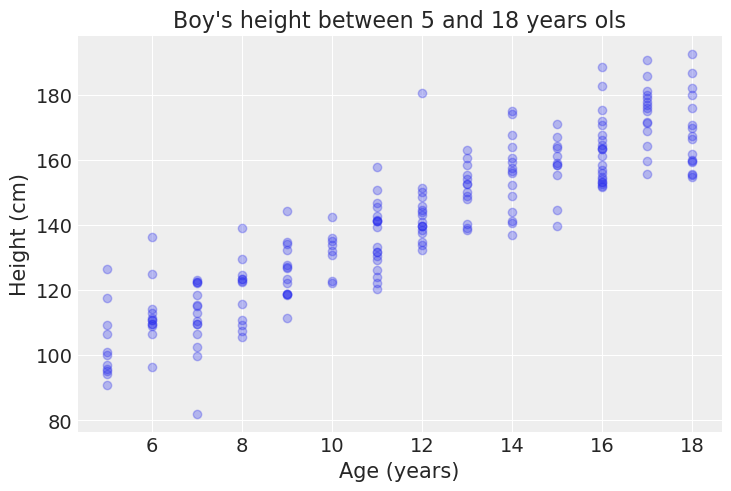

In [128]:
# Synthetic dataset ...

# True values
beta, alpha = 5.5, 76
sigma = 10

# Between 5 and 18 years old
np.random.seed(42)  # For reproductibility
x = np.random.randint(5, 19, size=200)

# Getting Heights
noise = np.random.normal(0, sigma, size=x.shape)  # Gaussian noise
y = alpha + beta * x + noise

# Créer un DataFrame
data = pd.DataFrame({"age": x, "height": y})

plt.scatter(data["age"], data["height"], alpha=0.3)
plt.ylabel("Height (cm)")
plt.xlabel("Age (years)")
plt.title("Boy's height between 5 and 18 years ols");

## Building a model

Building a model in PyMC is quite straightforward. If you’re not using a built-in model, you’ll need to start by creating an empty model:

In [213]:
import pymc as pm

my_linear_regression = pm.Model()

Then, within the model, we define the priors. Priors are the information we already have, or need to provide, for the model to make inferences. This information can come from expert knowledge or historical data. In our example, **we need to give priors for $\beta$, $\alpha$ and $\sigma$ (the predicted uncertainty) so the model knows what to estimate and how.**

There are many ways to choose priors, but that’s beyond the scope of this notebook. Here, we’ll use **weakly informative priors**, which means we provide broad ranges that cover our dataset, giving the model enough flexibility to learn from the data while keeping predictions realistic.

In [214]:
with my_linear_regression:
    alpha = pm.Normal("alpha", mu=100, sigma=5)
    beta = pm.Normal("beta", mu=1, sigma=5)
    sigma = pm.HalfNormal("sigma", sigma=1) # HalfNormal because stricly positive

Next, we define the relationship between our variables and the predicted outcome. Since we are doing linear regression, we’ll simply use the linear relation we introduced earlier:

In [215]:
with my_linear_regression:
    mu = alpha + beta * data["age"] 

Finally, we tell the model which variable we have actually observed:

In [216]:
with my_linear_regression:
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=data["height"])

## Using the model

Now that we’ve built the model, we can finally use it. First, as a sanity check, we can plot the prior distributions to see if our assumptions cover the range of the data. In other words, we check whether the priors we’ve chosen allow the model to capture the kind of patterns we expect to see.

Sampling: [Y_obs, alpha, beta, sigma]


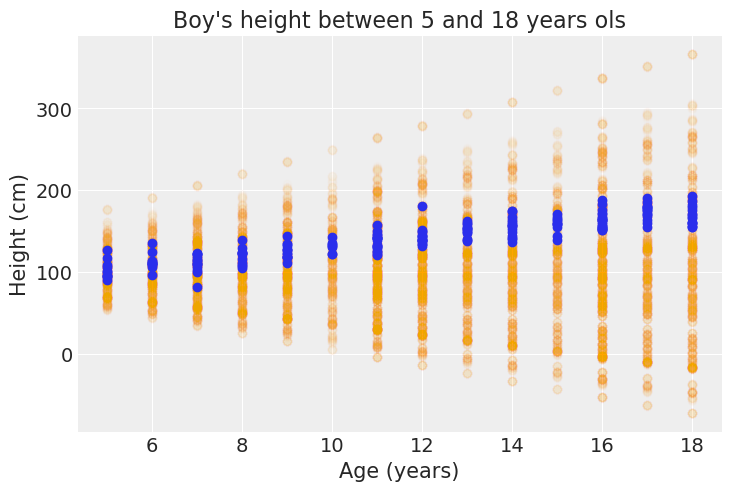

In [217]:
# Sampling without optimising
with my_linear_regression:
    prior_pred = pm.sample_prior_predictive(samples=100)

# Plotting
for i in range(100):
    plt.scatter(data["age"], prior_pred.prior_predictive["Y_obs"][0,i], color="orange", alpha=0.01)
plt.scatter(data["age"], data["height"])
plt.ylabel("Height (cm)")
plt.xlabel("Age (years)")
plt.title("Boy's height between 5 and 18 years ols");

At this stage, we should check two things: is the data within our predictions? And did we give the model enough range to explore all plausible parameter values? From the plot, we can answer both questions with yes. The blue points (our dataset) fall well within the range of the orange points (predicted values), and the range of the orange points is much wider than that of the blue points.

Now, to let the model perform inference, we simply call the ``sample`` method.

In [218]:
with my_linear_regression:
    idata = pm.sample() # inference data

c:\Users\jeanv\miniconda3\envs\PyBH\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


c:\Users\jeanv\miniconda3\envs\PyBH\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


Now, we can plot the estimated values of our $\alpha$, $\beta$ and $\sigma$ :

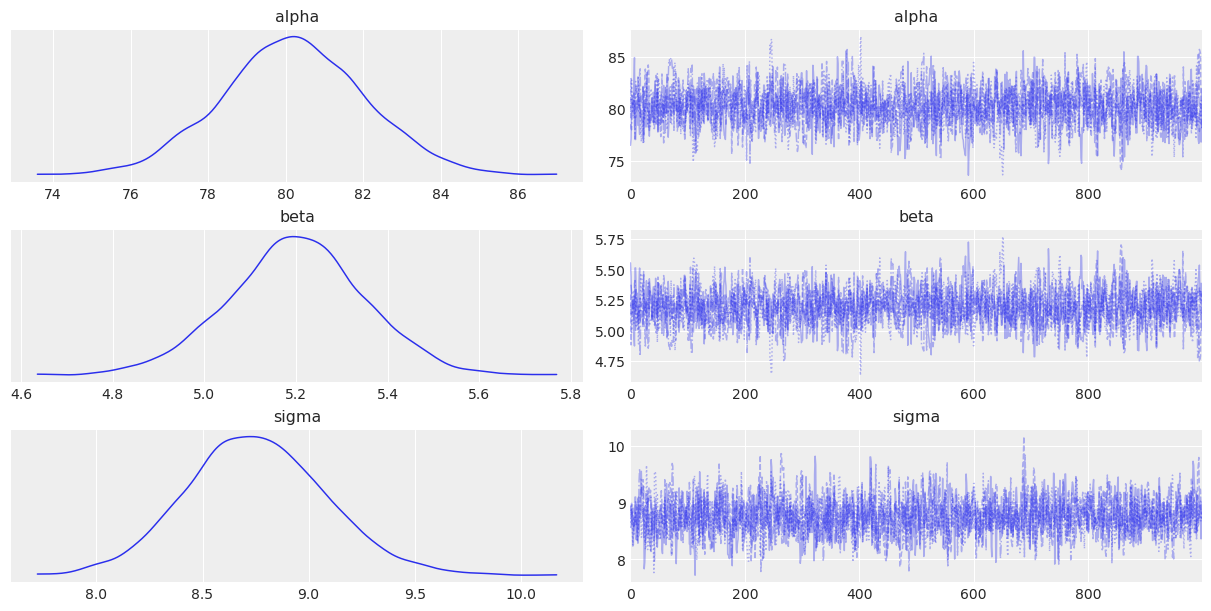

In [219]:
az.plot_trace(idata, combined=True);

Sampling: [Y_obs]


c:\Users\jeanv\miniconda3\envs\PyBH\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\jeanv\AppData\Local\Temp\ipykernel_9408\352680092.py:8: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  y_hdi = az.hdi(y_pred.T, hdi_prob=0.95)  # HDI = Highest Density Interval


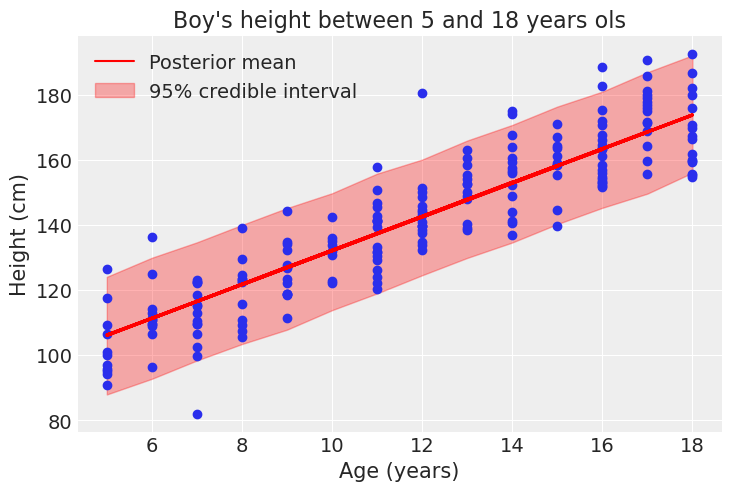

In [252]:
# Obtenir les prédictions postérieures (posterior predictive)
with my_linear_regression:
    post_pred = pm.sample_posterior_predictive(idata, var_names=["Y_obs"], random_seed=42)

# Calculer l'intervalle crédible à 95%
y_pred = post_pred.posterior_predictive["Y_obs"].stack(draws=("chain","draw")).values
y_mean = y_pred.mean(axis=1)
y_hdi = az.hdi(y_pred.T, hdi_prob=0.95)  # HDI = Highest Density Interval

# Tracer la moyenne et l'incertitude
plt.plot(x, y_mean, color='red', label='Posterior mean')
y_min = []
y_max = []
for i in np.arange(5, 19):
    y_min += [min(y_hdi[:,0][data["age"]==i])]
    y_max += [max(y_hdi[:,1][data["age"]==i])]
plt.fill_between(np.arange(5,19), y_min, y_max, color='red', alpha=0.3, label='95% credible interval')

plt.xlabel("Age")
plt.ylabel("Height")
plt.title("Bayesian Linear Regression with Uncertainty")
plt.legend()

plt.scatter(data["age"], data["height"])
plt.ylabel("Height (cm)")
plt.xlabel("Age (years)")
plt.title("Boy's height between 5 and 18 years ols");

In [251]:
print(y_min)

[]


In [14]:
df = pd.read_csv("../../../PyBH/data/diabetes.csv")

# Removing missing data
df = df[df["BloodPressure"] != 0]
df = df[df["Glucose"] != 0]
df = df[df["SkinThickness"] != 0]
df = df[df["BMI"] != 0]
df = df[df["Age"] != 0]
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
6,3,78,50,32,88,31.0,0.248,26,1


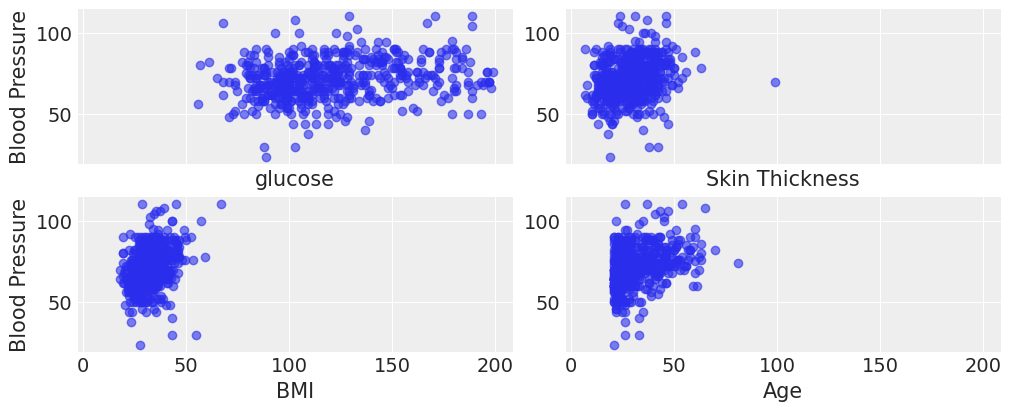

In [15]:
blood_press = df["BloodPressure"]
glucose = df["Glucose"]
skin_thic = df["SkinThickness"]
bmi = df["BMI"]
age = df["Age"]


fig, axes = plt.subplots(2, 2, sharex=True, figsize=(10, 4))

axes[0,0].scatter(glucose, blood_press, alpha=0.6)
axes[0,0].set_xlabel("glucose")
axes[0,0].set_ylabel("Blood Pressure")

axes[0,1].scatter(skin_thic, blood_press, alpha=0.6)
axes[0,1].set_xlabel("Skin Thickness")

axes[1,0].scatter(bmi, blood_press, alpha=0.6)
axes[1,0].set_xlabel("BMI")
axes[1,0].set_ylabel("Blood Pressure")

axes[1,1].scatter(age, blood_press, alpha=0.6)
axes[1,1].set_xlabel("Age");

In [25]:
# Combine les features
X = np.column_stack((glucose, skin_thic, bmi, age))
Y = np.array(blood_press)

# Création des coordonnées cohérentes avec les dims
coords = {
    "obs_ind": np.arange(X.shape[0]),
    "feature": ["glucose", "skin_thic", "bmi", "age"],
}

# Crée les DataArray avec des noms de dims explicites
X_da = xr.DataArray(X, dims=("obs_ind", "feature"), coords=coords)
X_da = X_da.astype('float32')
Y_da = xr.DataArray(Y[:,None], dims=("obs_ind", "treated_units"), coords={"obs_ind": coords["obs_ind"]})
Y_da = Y_da.astype('float32')

# Création du modèle (pas besoin de coords)
model = LinearRegression()

# Fit
model.fit(X_da, Y_da, coords);

c:\Users\jeanv\miniconda3\envs\PyBH\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


c:\Users\jeanv\miniconda3\envs\PyBH\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


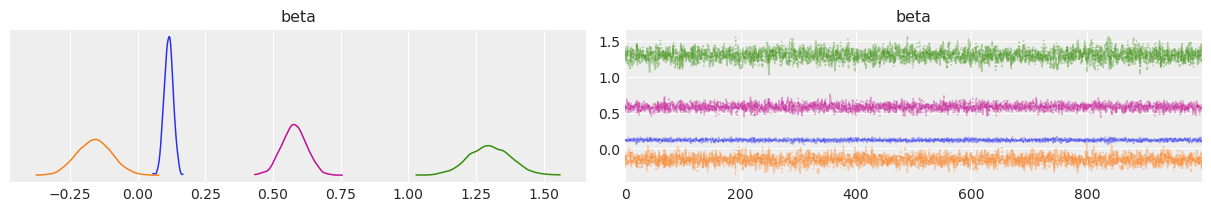

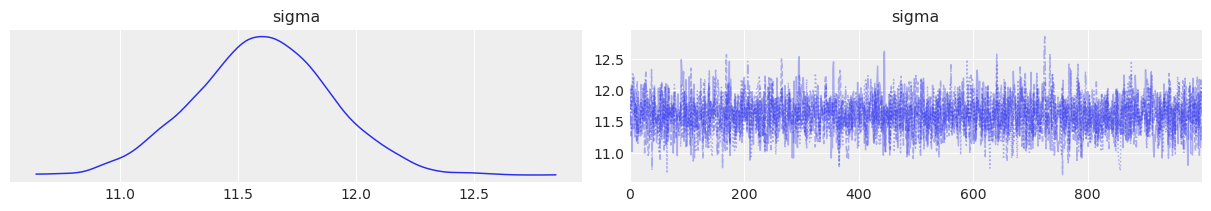

In [26]:
az.plot_trace(model.idata.posterior["beta"], combined=True);
az.plot_trace(model.idata.posterior["sigma"], combined=True);

In [27]:
Y_pred = model.predict(X_da)

Sampling: [y_hat]


In [52]:
Y_pred.observed_data = model.idata.observed_data

<Axes: xlabel='y_hat'>

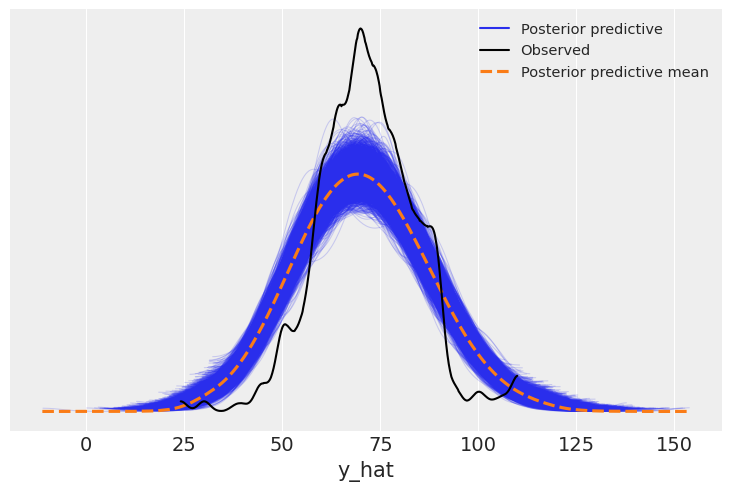

In [55]:
az.plot_ppc(Y_pred, data_pairs={"y": "y_hat"}, observed=True)

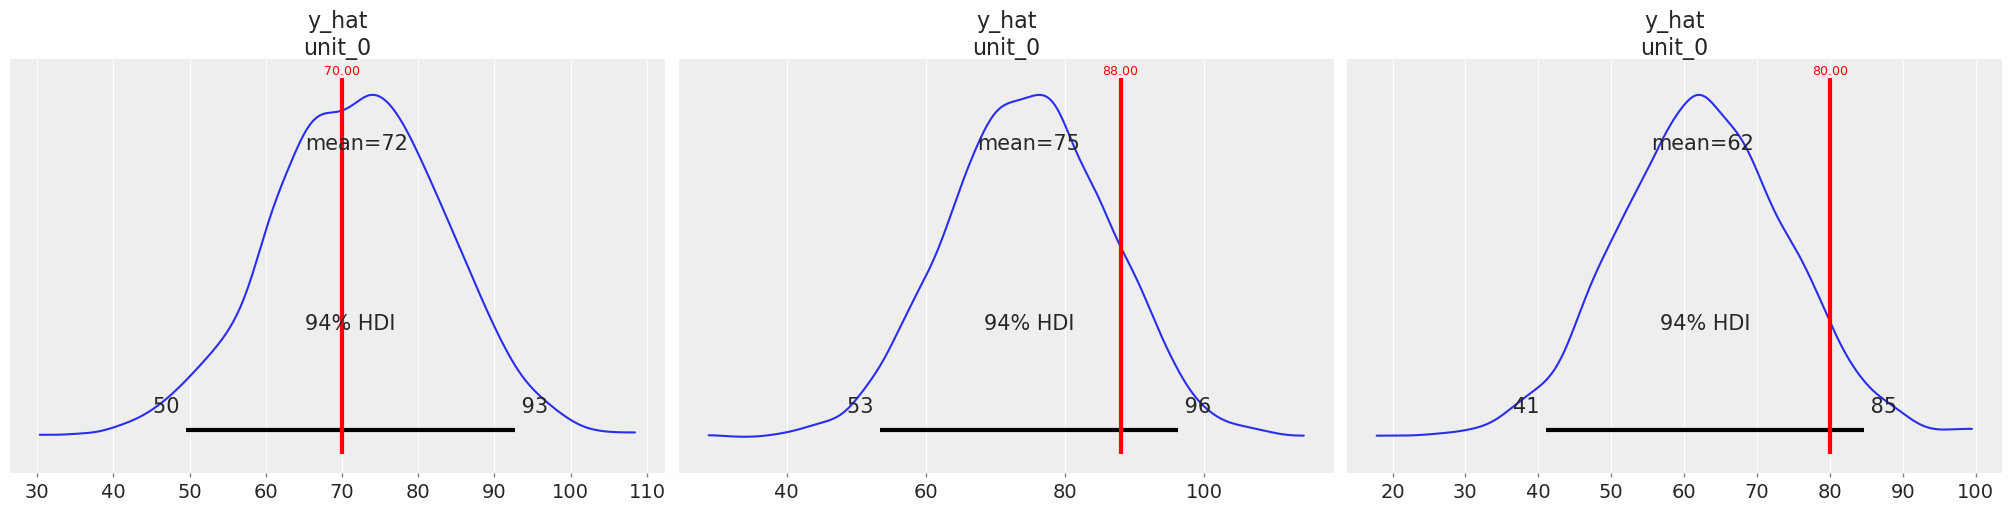

In [103]:
N=10

plt.figure(figsize=(20,5))
ax = plt.subplot(131)
az.plot_posterior(
    Y_pred.posterior_predictive["y_hat"],
    var_names=["y_hat"],
    coords={"obs_ind":N},
    ax=ax
)
ymin, ymax = ax.get_ylim()
plt.vlines(Y[N], ymin=ymin, ymax=ymax, lw=3, color='red')

ax.text(
        Y[N],
        ymax,  # position verticale
        f"{Y[N]:.2f}",  # format du texte
        color='red',
        ha='center',
        va='bottom',
        fontsize=9,
        rotation=0
    )

# ----------------------------------------------------------------

ax = plt.subplot(132)
az.plot_posterior(
    Y_pred.posterior_predictive["y_hat"],
    var_names=["y_hat"],
    coords={"obs_ind":N+1},
    ax=ax
)
ymin, ymax = ax.get_ylim()
plt.vlines(Y[N+1], ymin=ymin, ymax=ymax, lw=3, color='red')

ax.text(
        Y[N+1],
        ymax,  # position verticale
        f"{Y[N+1]:.2f}",  # format du texte
        color='red',
        ha='center',
        va='bottom',
        fontsize=9,
        rotation=0
    )

# -------------------------------------------------------------

ax = plt.subplot(133)
az.plot_posterior(
    Y_pred.posterior_predictive["y_hat"],
    var_names=["y_hat"],
    coords={"obs_ind":N+2},
    ax=ax
)
ymin, ymax = ax.get_ylim()
plt.vlines(Y[N+2], ymin=ymin, ymax=ymax, lw=3, color='red')

ax.text(
        Y[N+2],
        ymax,  # position verticale
        f"{Y[N+2]:.2f}",  # format du texte
        color='red',
        ha='center',
        va='bottom',
        fontsize=9,
        rotation=0
    );